In [20]:
import pandas as pd
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, Lars, BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew, boxcox
from scipy.special import boxcox1p, inv_boxcox
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [21]:
fnc = pd.read_csv('fnc.csv')
loading = pd.read_csv('loading.csv')
reveal = pd.read_csv('reveal_ID_site2.csv')
sample = pd.read_csv('sample_submission.csv')
train_scores = pd.read_csv('train_scores.csv')

fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])
loading = loading.drop(['IC_20'], axis=1)
loading_features.remove('IC_20')

In [22]:
"""SMN_cols = [x for x in list(fnc.columns) if x.startswith('SMN')]
VSN_cols = [x for x in list(fnc.columns) if x.startswith('VSN')]
DMN_cols = [x for x in list(fnc.columns) if x.startswith('DMN')]
SCN_cols = [x for x in list(fnc.columns) if x.startswith('SCN')]
CON_cols = [x for x in list(fnc.columns) if x.startswith('CON')]
ADN_cols = [x for x in list(fnc.columns) if x.startswith('ADN')]
CBN_cols = [x for x in list(fnc.columns) if x.startswith('CBN')]
linear_imp_cols = ['IC_22', 'IC_12', 'IC_15', 'IC_04', 'IC_10', 'IC_08', 'IC_21', 'IC_02']
linear_imp_cols = linear_imp_cols[:5]"""

"SMN_cols = [x for x in list(fnc.columns) if x.startswith('SMN')]\nVSN_cols = [x for x in list(fnc.columns) if x.startswith('VSN')]\nDMN_cols = [x for x in list(fnc.columns) if x.startswith('DMN')]\nSCN_cols = [x for x in list(fnc.columns) if x.startswith('SCN')]\nCON_cols = [x for x in list(fnc.columns) if x.startswith('CON')]\nADN_cols = [x for x in list(fnc.columns) if x.startswith('ADN')]\nCBN_cols = [x for x in list(fnc.columns) if x.startswith('CBN')]\nlinear_imp_cols = ['IC_22', 'IC_12', 'IC_15', 'IC_04', 'IC_10', 'IC_08', 'IC_21', 'IC_02']\nlinear_imp_cols = linear_imp_cols[:5]"

In [23]:
"""fnc_initials = list(set([x.split('(')[0] for x in fnc_features]))
fnc_initials_dict = {}
for i in fnc_initials:
    count = 0
    for f in fnc_features:
        if f.startswith(i):
            count += 1
    fnc_initials_dict[i] = count

print(fnc_initials,'\n', fnc_initials_dict)"""

"fnc_initials = list(set([x.split('(')[0] for x in fnc_features]))\nfnc_initials_dict = {}\nfor i in fnc_initials:\n    count = 0\n    for f in fnc_features:\n        if f.startswith(i):\n            count += 1\n    fnc_initials_dict[i] = count\n\nprint(fnc_initials,'\n', fnc_initials_dict)"

In [24]:
"""fnc_finals = np.zeros((fnc.shape[0],1))
for f in fnc_initials:
    
    reqd_features = [x for x in fnc_features if x.startswith(f)]

    to_be_pca = []
    corr_mat = abs((fnc[reqd_features].corr()))
    for i in range(len(reqd_features)):
        for j in range(i+1, len(reqd_features)):
            if corr_mat.iloc[i,j] >= 0.9:
                to_be_pca.append(reqd_features[i])
                to_be_pca.append(reqd_features[j])

    to_be_pca = list(set(to_be_pca))
    no_pca = [x for x in reqd_features if x not in to_be_pca]
    print(f, len(reqd_features), len(to_be_pca), len(no_pca))
    
    if len(to_be_pca) > 0:
        pca = PCA(n_components = len(to_be_pca)//6 + 1)
        fnc_finals = np.concatenate((fnc_finals, pca.fit_transform(fnc[to_be_pca])), axis=1)
    if len(no_pca) > 0:
        fnc_finals = np.concatenate((fnc_finals, fnc[no_pca]), axis=1)
    
fnc_finals = pd.DataFrame(fnc_finals[:,1:])
fnc_features = list(fnc_finals.columns)"""

'fnc_finals = np.zeros((fnc.shape[0],1))\nfor f in fnc_initials:\n    \n    reqd_features = [x for x in fnc_features if x.startswith(f)]\n\n    to_be_pca = []\n    corr_mat = abs((fnc[reqd_features].corr()))\n    for i in range(len(reqd_features)):\n        for j in range(i+1, len(reqd_features)):\n            if corr_mat.iloc[i,j] >= 0.9:\n                to_be_pca.append(reqd_features[i])\n                to_be_pca.append(reqd_features[j])\n\n    to_be_pca = list(set(to_be_pca))\n    no_pca = [x for x in reqd_features if x not in to_be_pca]\n    print(f, len(reqd_features), len(to_be_pca), len(no_pca))\n    \n    if len(to_be_pca) > 0:\n        pca = PCA(n_components = len(to_be_pca)//6 + 1)\n        fnc_finals = np.concatenate((fnc_finals, pca.fit_transform(fnc[to_be_pca])), axis=1)\n    if len(no_pca) > 0:\n        fnc_finals = np.concatenate((fnc_finals, fnc[no_pca]), axis=1)\n    \nfnc_finals = pd.DataFrame(fnc_finals[:,1:])\nfnc_features = list(fnc_finals.columns)'

In [25]:
#fnc_finals.shape, fnc.shape

In [26]:
#df = pd.concat([loading, fnc_finals], axis=1)
df = fnc.merge(loading, on="Id")

In [27]:
SEED = 0
NUM_FOLDS = 7
FNC_SCALE = 1/500

In [28]:
scaler = MinMaxScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
scaler = RobustScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

train_scores["is_train"] = True
df = df.merge(train_scores, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

In [29]:
df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [99]:
target = 'age'
features = loading_features + fnc_features 
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, df[df[target].notnull()][features], df[df[target].notnull()][target], scoring='neg_mean_squared_error', cv=NUM_FOLDS))
    return rmse

In [100]:
%%time

alphas_ridge = [ 0.003, 0.004, 0.0045, 0.005, 0.006 ]
cv_ridge = [rmse_cv(Ridge(alpha = al)).mean() for al in alphas_ridge]

CPU times: user 58.3 s, sys: 15.2 s, total: 1min 13s
Wall time: 19.1 s


In [101]:
cv_ridge = pd.Series(cv_ridge, index=alphas_ridge)
cv_ridge

0.0030    9.012055
0.0040    9.009862
0.0045    9.011237
0.0050    9.013565
0.0060    9.019998
dtype: float64

Text(0, 0.5, 'rmse')

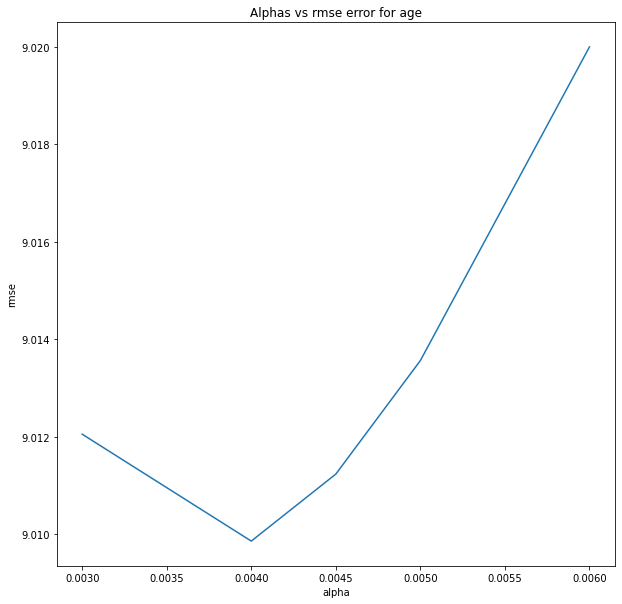

In [102]:
plt.figure(figsize=(10,10))
cv_ridge.plot(title='Alphas vs rmse error for {}'.format(target))
plt.xlabel('alpha')
plt.ylabel('rmse')

In [30]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
features = loading_features + fnc_features 
overal_score = 0
for target, c, w, al in [ ('age', 6, 0.3, 0.004), ('domain1_var1', 0, 0.175, 0.08),('domain1_var2', 0, 0.175, 0.22),('domain2_var1', 0, 0.175, 0.05),('domain2_var2', 0, 0.175, 0.047)]:    

    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha = al)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 5), np.round(score, 4))
    
print("\nOverall score:", np.round(overal_score, 5), np.round(overal_score, 4))

age 0.14293 0.1429
domain1_var1 0.15088 0.1509
domain1_var2 0.15124 0.1512
domain2_var1 0.18161 0.1816
domain2_var2 0.17614 0.1761

Overall score: 0.15836 0.1584


In [31]:
df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,domain1_var1,domain1_var2,domain2_var1,domain2_var2,is_train,pred_age,pred_domain1_var1,pred_domain1_var2,pred_domain2_var1,pred_domain2_var2
0,10001,0.000945,-0.000262,-0.000965,-0.001387,0.000215,0.001237,0.001981,-0.000118,-0.000913,...,30.571975,62.553736,53.325130,51.427998,True,60.822870,54.700506,58.298581,47.845224,50.522798
1,10002,-0.000809,-0.001810,-0.003311,-0.000653,-0.000085,0.000327,0.000038,0.000301,0.000269,...,50.969456,67.470628,60.651856,58.311361,True,57.336862,52.973276,59.478525,46.686522,52.121273
3,10004,-0.000962,0.000476,-0.000406,-0.001370,0.002247,0.001711,0.001306,0.000986,0.001270,...,53.152498,58.012103,52.418389,62.536641,True,51.267617,52.805469,58.794161,47.738351,49.958631
4,10005,0.000325,0.000419,-0.001196,0.000239,-0.001076,-0.000483,-0.001026,0.001065,0.000052,...,NaN,NaN,52.108977,69.993075,True,60.446991,57.373484,59.401153,49.026623,53.414617
6,10007,-0.001846,0.000424,0.000453,-0.001411,0.000813,-0.000762,-0.000675,-0.000242,0.000446,...,49.197021,65.674285,40.151376,34.096421,True,45.828514,50.494041,58.029964,46.180627,52.216008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11745,21746,-0.001715,-0.000982,-0.001203,-0.000471,0.000718,0.001871,0.001547,-0.000342,-0.000036,...,21.358872,61.165998,51.778483,54.640179,True,34.493118,49.482581,59.778044,45.276759,50.259935
11746,21747,-0.000079,0.000074,0.000781,0.001393,0.000601,-0.000881,-0.001782,-0.000496,-0.001957,...,68.169675,29.907995,55.349257,54.019517,True,52.377009,49.075877,59.793511,45.949601,52.553658
11749,21750,-0.000192,-0.003407,-0.002961,-0.000419,-0.000040,-0.001048,-0.001081,-0.000855,-0.000076,...,55.114811,60.878271,38.617246,50.679885,True,41.255301,49.332348,60.165816,45.510735,53.243611
11751,21752,-0.001080,0.002042,0.000844,-0.000611,0.000800,0.000774,0.001018,0.000272,0.001258,...,59.844808,72.303110,55.458281,46.870235,True,54.258982,55.096018,58.158289,47.973709,51.256757


In [32]:
test_df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_30,IC_22,IC_29,IC_14,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,is_train
2,10003,0.000742,-0.000722,0.002262,0.000876,-0.003375,-0.002673,-0.001074,-0.001635,-0.001671,...,0.442824,-1.775035,0.919861,0.426380,59.621590,47.923768,60.546380,50.207074,56.366845,NaN
5,10006,0.000579,-0.000663,0.001188,-0.001581,-0.000762,-0.001595,-0.000476,-0.001474,-0.000938,...,0.399060,-2.008145,0.383092,1.289933,63.221566,54.127353,58.603542,49.021390,51.499722,NaN
9,10010,-0.003868,-0.001960,-0.002069,-0.001596,0.000328,-0.001246,0.000071,0.001441,0.001240,...,0.344786,0.620806,0.160646,-0.297477,36.311940,49.414108,59.759476,45.023978,52.574997,NaN
10,10011,-0.000682,-0.000268,-0.000084,-0.000775,0.000440,0.000536,0.000713,0.001567,0.001218,...,-0.881252,0.141667,1.320557,0.687784,51.332090,52.161755,60.402143,48.413925,49.458295,NaN
11,10012,0.002167,0.000788,0.000706,0.002741,-0.002142,0.000181,0.001373,0.001324,0.001787,...,-0.045193,-1.175665,-0.309554,1.609493,52.620711,54.635945,56.209431,46.046612,58.529022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,21745,-0.000797,0.000713,-0.000813,0.001230,-0.000409,0.000613,0.001370,0.003909,0.002680,...,1.092471,0.309866,0.220979,0.471946,39.161586,51.004256,58.408205,45.357834,53.723536,NaN
11747,21748,-0.004425,-0.000731,-0.002159,0.002388,-0.000780,0.000332,-0.000186,0.000455,0.000135,...,1.612417,-0.673536,-0.406932,0.267300,52.926739,57.387191,60.000903,47.947990,51.541814,NaN
11748,21749,-0.001031,-0.001388,-0.001598,0.000004,0.001802,0.002070,0.000905,0.002052,0.000966,...,-1.074807,1.624656,0.520447,-0.134799,40.489636,46.170253,59.263155,45.255353,50.869998,NaN
11750,21751,0.001645,0.002298,0.000645,0.001401,0.002766,-0.000568,0.001205,0.002192,0.001788,...,-0.431042,0.798420,1.592151,0.281489,40.356583,51.341735,58.289608,45.203436,56.220450,NaN


In [47]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
features = loading_features + fnc_features 
targets_df = ['pred_age','pred_domain1_var1','pred_domain1_var2','pred_domain2_var1','pred_domain2_var2']
targets_test = ['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']
overal_score = 0
for target, w, al in [ ('age', 0.3, 0.004), ('domain1_var1', 0.175, 0.08),('domain1_var2', 0.175, 0.22),('domain2_var1', 0.175, 0.05),('domain2_var2', 0.175, 0.047)]:    

    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    df_copy = df.copy()
    test_df_copy = test_df.copy()
    
    #targets_df.remove('pred_{}'.format(target))
    #targets_test.remove(target)
    
    scaler = MinMaxScaler()
    df_copy.loc[:,targets_df] = scaler.fit_transform(df_copy.loc[:,targets_df])
    scaler = RobustScaler()
    df_copy.loc[:,targets_df] = scaler.fit_transform(df_copy.loc[:,targets_df])
    df_copy.loc[:,targets_df]/=10
    
    scaler = MinMaxScaler()
    test_df_copy.loc[:,targets_test] = scaler.fit_transform(test_df_copy.loc[:,targets_test])
    scaler = RobustScaler()
    test_df_copy.loc[:,targets_test] = scaler.fit_transform(test_df_copy.loc[:,targets_test])
    test_df_copy.loc[:,targets_test] /= 10
    
    train_features = features + targets_df
    test_features = features + targets_test

    for f, (train_ind, val_ind) in enumerate(kf.split(df_copy, df_copy)):
        train_df, val_df = df_copy.iloc[train_ind], df_copy.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha = al)
        model.fit(train_df[train_features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[train_features])
        y_test[:, f] = model.predict(test_df_copy[test_features])
        
    df["pred_meta_{}".format(target)] = y_oof
    test_df["meta_{}".format(target)] = y_test.mean(axis=1)
    
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_meta_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 5), np.round(score, 4))
    
    del df_copy, test_df_copy
    #targets_df.append('pred_{}'.format(target))
    #targets_test.append(target)
    
print("\nOverall score:", np.round(overal_score, 5), np.round(overal_score, 4))

age 0.14048 0.1405
domain1_var1 0.14968 0.1497
domain1_var2 0.14935 0.1494
domain2_var1 0.17915 0.1791
domain2_var2 0.17366 0.1737

Overall score: 0.15622 0.1562


In [42]:
df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,pred_age,pred_domain1_var1,pred_domain1_var2,pred_domain2_var1,pred_domain2_var2,pred_meta_age,pred_meta_domain1_var1,pred_meta_domain1_var2,pred_meta_domain2_var1,pred_meta_domain2_var2
0,10001,0.000945,-0.000262,-0.000965,-0.001387,0.000215,0.001237,0.001981,-0.000118,-0.000913,...,60.822870,54.700506,58.298581,47.845224,50.522798,60.437349,54.400429,59.236999,48.163216,51.542592
1,10002,-0.000809,-0.001810,-0.003311,-0.000653,-0.000085,0.000327,0.000038,0.000301,0.000269,...,57.336862,52.973276,59.478525,46.686522,52.121273,56.993603,53.606607,59.064836,47.413086,52.145405
3,10004,-0.000962,0.000476,-0.000406,-0.001370,0.002247,0.001711,0.001306,0.000986,0.001270,...,51.267617,52.805469,58.794161,47.738351,49.958631,51.291361,52.631561,59.161857,47.851101,50.291948
4,10005,0.000325,0.000419,-0.001196,0.000239,-0.001076,-0.000483,-0.001026,0.001065,0.000052,...,60.446991,57.373484,59.401153,49.026623,53.414617,60.240708,57.422714,58.330728,48.651241,52.938204
6,10007,-0.001846,0.000424,0.000453,-0.001411,0.000813,-0.000762,-0.000675,-0.000242,0.000446,...,45.828514,50.494041,58.029964,46.180627,52.216008,45.184903,51.446935,59.989658,47.072190,52.274091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11745,21746,-0.001715,-0.000982,-0.001203,-0.000471,0.000718,0.001871,0.001547,-0.000342,-0.000036,...,34.493118,49.482581,59.778044,45.276759,50.259935,34.468314,48.995417,60.185342,44.610646,49.999566
11746,21747,-0.000079,0.000074,0.000781,0.001393,0.000601,-0.000881,-0.001782,-0.000496,-0.001957,...,52.377009,49.075877,59.793511,45.949601,52.553658,53.588452,49.774276,59.025051,47.693945,53.952944
11749,21750,-0.000192,-0.003407,-0.002961,-0.000419,-0.000040,-0.001048,-0.001081,-0.000855,-0.000076,...,41.255301,49.332348,60.165816,45.510735,53.243611,41.506796,49.100719,59.408393,45.369775,53.235779
11751,21752,-0.001080,0.002042,0.000844,-0.000611,0.000800,0.000774,0.001018,0.000272,0.001258,...,54.258982,55.096018,58.158289,47.973709,51.256757,54.596268,54.156683,59.810995,48.305820,52.720315


In [43]:
test_df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,domain1_var1,domain1_var2,domain2_var1,domain2_var2,is_train,meta_age,meta_domain1_var1,meta_domain1_var2,meta_domain2_var1,meta_domain2_var2
2,10003,0.000742,-0.000722,0.002262,0.000876,-0.003375,-0.002673,-0.001074,-0.001635,-0.001671,...,47.923768,60.546380,50.207074,56.366845,NaN,58.718015,49.159053,60.187182,50.157359,55.064548
5,10006,0.000579,-0.000663,0.001188,-0.001581,-0.000762,-0.001595,-0.000476,-0.001474,-0.000938,...,54.127353,58.603542,49.021390,51.499722,NaN,62.683079,55.373461,57.445360,50.060041,51.442273
9,10010,-0.003868,-0.001960,-0.002069,-0.001596,0.000328,-0.001246,0.000071,0.001441,0.001240,...,49.414108,59.759476,45.023978,52.574997,NaN,35.995798,49.091281,59.702347,44.688803,52.532433
10,10011,-0.000682,-0.000268,-0.000084,-0.000775,0.000440,0.000536,0.000713,0.001567,0.001218,...,52.161755,60.402143,48.413925,49.458295,NaN,50.861390,52.035859,59.478588,47.681008,48.489983
11,10012,0.002167,0.000788,0.000706,0.002741,-0.002142,0.000181,0.001373,0.001324,0.001787,...,54.635945,56.209431,46.046612,58.529022,NaN,52.253733,54.779180,57.347680,44.360648,56.664085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,21745,-0.000797,0.000713,-0.000813,0.001230,-0.000409,0.000613,0.001370,0.003909,0.002680,...,51.004256,58.408205,45.357834,53.723536,NaN,38.689606,50.144157,58.507172,44.495663,53.484702
11747,21748,-0.004425,-0.000731,-0.002159,0.002388,-0.000780,0.000332,-0.000186,0.000455,0.000135,...,57.387191,60.000903,47.947990,51.541814,NaN,53.193826,55.943148,58.825149,47.183319,52.025946
11748,21749,-0.001031,-0.001388,-0.001598,0.000004,0.001802,0.002070,0.000905,0.002052,0.000966,...,46.170253,59.263155,45.255353,50.869998,NaN,40.158141,46.462215,59.767504,45.860624,51.340409
11750,21751,0.001645,0.002298,0.000645,0.001401,0.002766,-0.000568,0.001205,0.002192,0.001788,...,51.341735,58.289608,45.203436,56.220450,NaN,40.045210,51.592093,58.431742,44.160806,54.929629


In [44]:
sub_df = pd.melt(test_df[["Id", "meta_age", "meta_domain1_var1", "meta_domain1_var2", "meta_domain2_var1", "meta_domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df.variable = sub_df.variable.apply(lambda x: x.replace('meta_',''))
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

,Id,Predicted
0,10003_age,58.718015
5877,10003_domain1_var1,49.159053
11754,10003_domain1_var2,60.187182
17631,10003_domain2_var1,50.157359
23508,10003_domain2_var2,55.064548
1,10006_age,62.683079
5878,10006_domain1_var1,55.373461
11755,10006_domain1_var2,57.445360
17632,10006_domain2_var1,50.060041
23509,10006_domain2_var2,51.442273


In [46]:
sub_df.to_csv('subs/checking_effect_of_meta_with_targetself.csv', index=False)

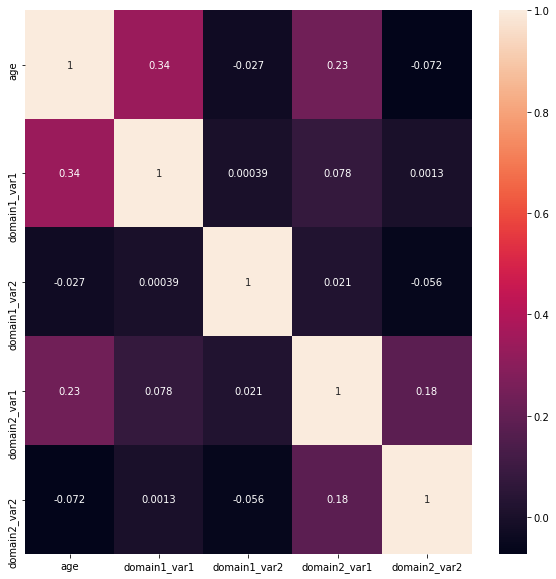

In [63]:
plt.figure(figsize=(10,10))
sns.heatmap(train_scores.iloc[:,1:6].corr(), annot=True)

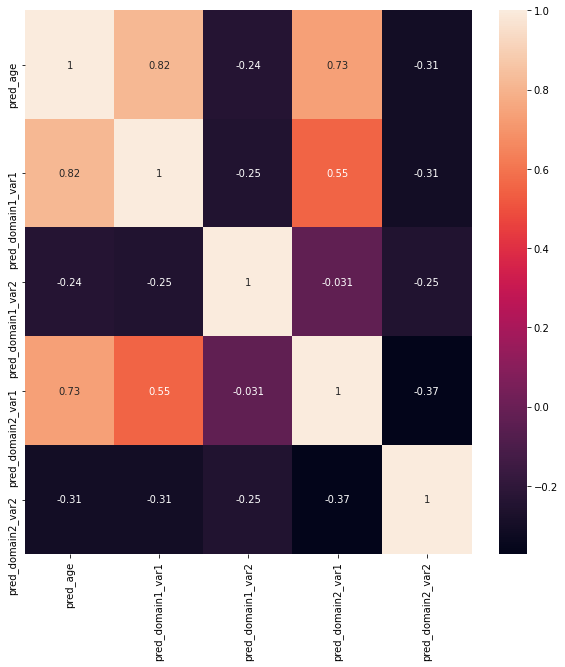

In [49]:
plt.figure(figsize=(10,10))
sns.heatmap(df[['pred_age','pred_domain1_var1','pred_domain1_var2','pred_domain2_var1','pred_domain2_var2']].corr(), annot=True)

In [51]:
#maybe high correlation between target values